In [ ]:
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap, jacfwd, jacrev
import optax
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

In [ ]:
# Define domain, BC

xmin_org, xmax_org = 0, 1e+4
ymin_org, ymax_org = 0 , 1e+4
delta_x = xmax_org - xmin_org
delta_y = ymax_org - ymin_org

xmin = xmin_org/delta_x
xmax = xmax_org/delta_x
ymin = ymin_org/delta_y
ymax = ymax_org/delta_y

# Define the boundary conditions
h1 = 60            # at x = 0 for all y_b1, Dirichlet boundary at the left (m)
h2 = 0             # at x = 1 for all y, Dirichlet boundary at the right (m)
dh_dy1 = 0           # at y = 0 for all x, Neumann boundary at the bottom (m)
dh_dy2 = 0           # at y = 1 for all x, Neumann boundary at the top (m)

# define the number of points on each boundary and
N_b = 100          # Number of boundary condition points on each side.
N_r = 5000        # Number of collocation points within the domain

In [ ]:
key = jax.random.PRNGKey(42)
key, key_left, key_right = jax.random.split(key, 3)

def generate_BCs_and_colloc(key, N_b, N_r, ymin, ymax, xmin_dom, xmax_dom, h_left, h_right, dh_dy1, dh_dy2):
    bk1, bk2, bk3, bk4, r1k, r2k = jax.random.split(key, 6)

    # Left boundary (Dirichlet)
    y_b1 = jax.random.uniform(bk1, minval=ymin, maxval=ymax, shape=(N_b, 1))
    x_b1 = jnp.ones_like(y_b1) * xmin_dom
    bc_1 = jnp.ones_like(y_b1) * h_left
    BC_1 = jnp.concatenate([x_b1, y_b1, bc_1], axis=1)

    # Right boundary (Dirichlet)
    y_b2 = jax.random.uniform(bk2, minval=ymin, maxval=ymax, shape=(N_b, 1))
    x_b2 = jnp.ones_like(y_b2) * xmax_dom
    bc_2 = jnp.ones_like(y_b2) * h_right
    BC_2 = jnp.concatenate([x_b2, y_b2, bc_2], axis=1)

    # Bottom boundary (Neumann)
    x_b3 = jax.random.uniform(bk3, minval=xmin_dom, maxval=xmax_dom, shape=(N_b, 1))
    y_b3 = jnp.zeros_like(x_b3)
    bc_3 = jnp.ones_like(x_b3) * dh_dy1
    BC_3 = jnp.concatenate([x_b3, y_b3, bc_3], axis=1)

    # Upper boundary (Neumann)
    x_b4 = jax.random.uniform(bk4, minval=xmin_dom, maxval=xmax_dom, shape=(N_b, 1))
    y_b4 = jnp.ones_like(x_b4) * ymax
    bc_4 = jnp.ones_like(x_b4) * dh_dy2
    BC_4 = jnp.concatenate([x_b4, y_b4, bc_4], axis=1)

    conds = [BC_1, BC_2, BC_3, BC_4]

    # Collocation point
    y_c = jax.random.uniform(r1k, minval=ymin, maxval=ymax, shape=(N_r, 1))
    x_c = jax.random.uniform(r2k, minval=xmin_dom, maxval=xmax_dom, shape=(N_r, 1))
    colloc = jnp.concatenate([x_c, y_c], axis=1)

    return conds, colloc

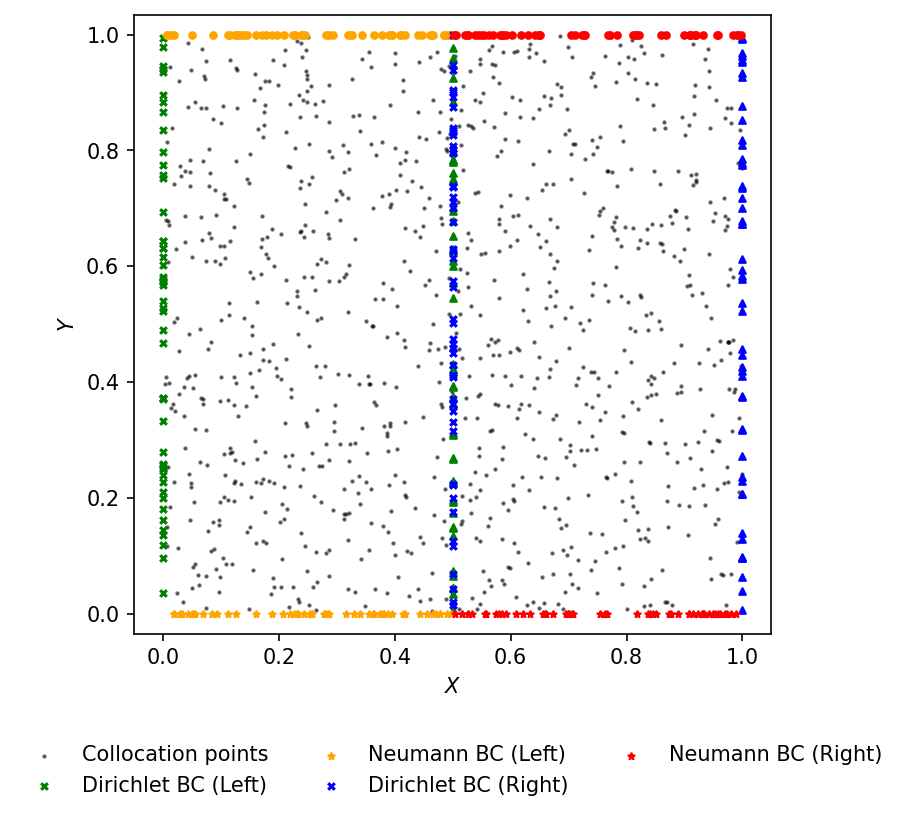

In [ ]:
# Visualization of points

def plot_combined_domain(conds_left, colloc_left, conds_right, colloc_right):
    plt.figure(figsize=(5, 5.5), dpi=150)

    # Plot collocation points
    s_colloc = 5
    plt.scatter(colloc_left[:, 0], colloc_left[:, 1], c='k', marker='.', alpha=0.5, label='Collocation points', s=s_colloc)
    plt.scatter(colloc_right[:, 0], colloc_right[:, 1], c='k', marker='.', alpha=0.5, s=s_colloc)

    # Plot boundary points
    s_bc = 10
    plt.scatter(conds_left[0][:, 0], conds_left[0][:, 1], c='green', marker='x', s=s_bc, label='Dirichlet BC (Left)')
    plt.scatter(conds_left[1][:, 0], conds_left[1][:, 1], c='green', marker='^', s=s_bc)
    plt.scatter(conds_left[2][:, 0], conds_left[2][:, 1], c='orange', marker='*', s=s_bc, label='Neumann BC (Left)')
    plt.scatter(conds_left[3][:, 0], conds_left[3][:, 1], c='orange', marker='o', s=s_bc)
    plt.scatter(conds_right[0][:, 0], conds_right[0][:, 1], c='blue', marker='x', s=s_bc, label='Dirichlet BC (Right)')
    plt.scatter(conds_right[1][:, 0], conds_right[1][:, 1], c='blue', marker='^', s=s_bc)
    plt.scatter(conds_right[2][:, 0], conds_right[2][:, 1], c='red', marker='*', s=s_bc, label='Neumann BC (Right)')
    plt.scatter(conds_right[3][:, 0], conds_right[3][:, 1], c='red', marker='o', s=s_bc)

    plt.xlabel('$X$')
    plt.ylabel('$Y$')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.axis('equal')

    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.95)

    plt.show()

N_b, N_r = 50, 500
ymin, ymax = 0.0, 1.0

# 1. Generate left domain
xmin_dom, xmax_dom = 0.0, 0.5
h_left, h_right = 1.0, 0.5
dh_dy1, dh_dy2 = 0.0, 0.0
conds_left, colloc_left = generate_BCs_and_colloc(
    key_left, N_b, N_r, ymin, ymax, xmin_dom, xmax_dom, h_left, h_right, dh_dy1, dh_dy2
)

# 2. Generate right domain
xmin_dom, xmax_dom = 0.5, 1.0
h_left, h_right = 0.5, 0.0
dh_dy1, dh_dy2 = 0.0, 0.0
conds_right, colloc_right = generate_BCs_and_colloc(
    key_right, N_b, N_r, ymin, ymax, xmin_dom, xmax_dom, h_left, h_right, dh_dy1, dh_dy2
)

# 3. Plot both (left+right) domain
plot_combined_domain(conds_left, colloc_left, conds_right, colloc_right)

In [ ]:
def hydraulic_conductivity(x, y):
  T_x = jnp.ones_like(x)*15/10
  T_y = jnp.ones_like(y)*15/10
  return T_x, T_y

In [ ]:
def pde_residual_2d_darcy(x,y,h):
    """
    Compute the PDE residual for the 2D Laplace equation.

    Inputs:
    x, y: Coordinates of collocation points (N x 1).
    h: Lambda function representing the neural network solution h(x, y).

    Output:
    Residual of the PDE at the collocation points (N x 1).
    """
    T_x, T_y = hydraulic_conductivity(x, y)

    h_x = lambda x,y:jax.grad(lambda x,y:jnp.sum(h(x,y)),0)(x,y)
    h_xx = lambda x,y:jax.grad(lambda x,y:jnp.sum(h_x(x,y)),0)(x,y)

    h_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(h(x,y)),1)(x,y)
    h_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(h_y(x,y)),1)(x,y)

    return T_x*h_xx(x,y) + T_y*h_yy(x,y)

In [ ]:
# Define Neural Network Architecture
def neural_net(params, x, y):
    """
    Forward pass of a neural network to predict h(x, y).

    Inputs:
    params: Neural network parameters (list of weights and biases).
    x, y: Input coordinates (N x 1).

    Output:
    Predicted h(x, y) values (N x 1).
    """
    X = jnp.concatenate([x, y],axis=1)
    *hidden,last = params
    for layer in hidden :
        X = jax.nn.tanh(X@layer['W']+layer['B'])
    return X@last['W'] + last['B']


# Function to initialize parameters of the neural network (weights and biases)
def init_params(layers):
    """
    Initialize parameters (weights and biases) for a neural network with specified layers.

    Args:
        layers: List of integers representing the number of nodes in each layer.
                For example, [2, 20, 20, 1] creates a network with input layer (2 nodes),
                two hidden layers (20 nodes each), and an output layer (1 node).

    Returns:
        params: List of dictionaries containing 'W' (weights) and 'B' (biases) for each layer.
    """
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)  # Generate random keys for each layer
    params = list()  # Initialize a list to store layer parameters

    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):  # Loop through layer dimensions
        lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in))  # Xavier initialization bounds
        W = lb + (ub - lb) * jax.random.uniform(key, shape=(n_in, n_out))  # Initialize weights
        B = jax.random.uniform(key, shape=(n_out,))  # Initialize biases
        params.append({'W': W, 'B': B})  # Append layer parameters (weights and biases) to the list

    return params  # Return the initialized parameters

In [ ]:
@jax.jit
def loss_fun(params, colloc, conds):
    h_nn = lambda x, y: neural_net(params, x, y)

    # PDE residual
    x_c, y_c = colloc[:, [0]], colloc[:, [1]]
    pde_res_c = pde_residual_2d_darcy(x_c, y_c, h_nn)
    pde_loss = jnp.mean(pde_res_c**2)

    # Dirichlet BC loss
    dbc_loss = 0.0
    for cond in conds[0:2]:
        x_b, y_b, u_b = cond[:, [0]], cond[:, [1]], cond[:, [2]]
        dbc_loss += jnp.mean((h_nn(x_b, y_b) - u_b)**2)

    # Neumann BC loss
    nbc_loss = 0.0
    h_nn_y = lambda x, y: jax.grad(lambda yy: jnp.sum(h_nn(x, yy)))(y)
    for cond in conds[2:4]:
        x_b, y_b, u_b = cond[:, [0]], cond[:, [1]], cond[:, [2]]
        nbc_loss += jnp.mean((h_nn_y(x_b, y_b) - u_b)**2)

    # Total loss (data_loss 제거)
    loss = 1 * pde_loss + 20 * dbc_loss + nbc_loss

    return loss

In [ ]:
#%% PINN prediction and plotting results
nx = 31
x = np.linspace(xmin, xmax, nx)
dx = x[1] - x[0]
ny = 31
y = np.linspace(ymin, ymax, ny)
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)

In [ ]:
# Parameters update function with RIV support
@jax.jit
def update(opt_state, params, colloc, conds):
    grads = jax.grad(loss_fun, 0)(params, colloc, conds)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

# Definition of hyperparameters
hidden_nodes = 20
hidden_layers = 3
epochs = 50000

# Scheduling learning rate
initial_learning_rate = 1e-3
lr_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=5000,
    decay_rate=0.9
)

# --- Tranining left domain (x: 0 ~ 0.5) ---
print("="*30)
print("### Start left domain training ###")
print("="*30)

xmin_left, xmax_left = 0.0, 0.5
h_bc_left = 60.0
h_bc_center = 22.5003 # recharge 없는 버전

conds_left, colloc_left = generate_BCs_and_colloc(
    key_left, N_b, N_r//2, ymin, ymax, xmin_left, xmax_left, h_bc_left, h_bc_center, dh_dy1, dh_dy2
)

# Initialization of model and optimizer
params_left = init_params([2] + [hidden_nodes] * hidden_layers + [1])
optimizer = optax.adam(learning_rate=lr_schedule)
opt_state = optimizer.init(params_left)

# Left domain traning loop
best_loss_left = float('inf')
for epoch in range(epochs + 1):
    opt_state, params_left = update(opt_state, params_left, colloc_left, conds_left)
    if epoch % 1000 == 0:
        current_loss = loss_fun(params_left, colloc_left, conds_left)
        if current_loss < best_loss_left:
            best_loss_left = current_loss
            best_params_left = params_left
        print(f'LEFT Domain - Epoch={epoch}\tloss={current_loss:.3e}')

print(f'Finish left domain training! Best Loss = {best_loss_left:.3e}')

# --- Tranining right domain  (x: 0.5 ~ 1.0) ---
print("\n" + "="*30)
print("### Start right domain training ###")
print("="*30)

xmin_right, xmax_right = 0.5, 1.0
h_bc_right = 0.0

conds_right, colloc_right = generate_BCs_and_colloc(
    key_right, N_b, N_r//2, ymin, ymax, xmin_right, xmax_right, h_bc_center, h_bc_right, dh_dy1, dh_dy2
)

# Initialization of model and optimizer
params_right = init_params([2] + [hidden_nodes] * hidden_layers + [1])
optimizer = optax.adam(learning_rate=lr_schedule)
opt_state = optimizer.init(params_right)

# Right domain traning loop
best_loss_right = float('inf')
for epoch in range(epochs + 1):
    opt_state, params_right = update(opt_state, params_right, colloc_right, conds_right)
    if epoch % 1000 == 0:
        current_loss = loss_fun(params_right, colloc_right, conds_right)
        if current_loss < best_loss_right:
            best_loss_right = current_loss
            best_params_right = params_right
        print(f'RIGHT Domain - Epoch={epoch}\tloss={current_loss:.3e}')

print(f'Finish right domain training! Best Loss = {best_loss_right:.3e}')

### 왼쪽 도메인 학습 시작 (관측 데이터 없음) ###
LEFT Domain - Epoch=0	loss=7.968e+04
LEFT Domain - Epoch=1000	loss=2.914e+04
LEFT Domain - Epoch=2000	loss=1.629e+04
LEFT Domain - Epoch=3000	loss=1.417e+04
LEFT Domain - Epoch=4000	loss=1.406e+04
LEFT Domain - Epoch=5000	loss=9.056e+03
LEFT Domain - Epoch=6000	loss=2.749e+02
LEFT Domain - Epoch=7000	loss=8.779e+00
LEFT Domain - Epoch=8000	loss=1.648e+00
LEFT Domain - Epoch=9000	loss=1.682e+00
LEFT Domain - Epoch=10000	loss=1.270e+00
LEFT Domain - Epoch=11000	loss=3.570e-01
LEFT Domain - Epoch=12000	loss=8.487e-01
LEFT Domain - Epoch=13000	loss=3.263e-01
LEFT Domain - Epoch=14000	loss=3.088e-01
LEFT Domain - Epoch=15000	loss=3.128e-01
LEFT Domain - Epoch=16000	loss=2.134e+00
LEFT Domain - Epoch=17000	loss=1.367e+00
LEFT Domain - Epoch=18000	loss=7.341e-01
LEFT Domain - Epoch=19000	loss=1.525e-01
LEFT Domain - Epoch=20000	loss=1.898e-01
LEFT Domain - Epoch=21000	loss=5.218e-01
LEFT Domain - Epoch=22000	loss=8.087e-01
LEFT Domain - Epoch=23000	loss=1.604e


결과 통합 및 시각화 중...
스타일이 적용된 최종 결과 플롯 생성...


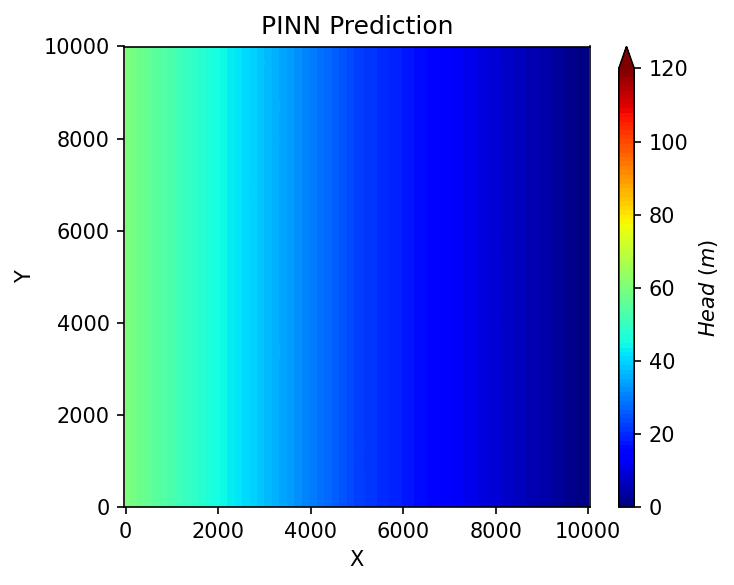

In [ ]:
# Visualize head distribution

# --- 1. Define Normalization Parameters (Required) ---
xmin_org, xmax_org = 0, 1e+4
ymin_org, ymax_org = 0, 1e+4
delta_x = xmax_org - xmin_org
delta_y = ymax_org - ymin_org

# Normalized coordinates (used for prediction)
xmin = xmin_org / delta_x # 0.0
xmax = xmax_org / delta_x # 1.0
ymin = ymin_org / delta_y # 0.0
ymax = ymax_org / delta_y # 1.0

# --- 2. Generate 'Normalized' Grid for Prediction ---
nx = 31
ny = 31
x_norm = np.linspace(xmin, xmax, nx)
y_norm = np.linspace(ymin, ymax, ny)
X_norm, Y_norm = np.meshgrid(x_norm, y_norm)
X_flat_norm = X_norm.flatten().reshape(-1, 1)
Y_flat_norm = Y_norm.flatten().reshape(-1, 1)

# --- 3. Perform Prediction using Normalized Coordinates ---
pinn_h_combined = np.zeros_like(X_flat_norm)
mask_left_1d = (X_flat_norm < 0.5).flatten()
mask_right_1d = ~mask_left_1d

x_input_left = X_flat_norm[mask_left_1d]
y_input_left = Y_flat_norm[mask_left_1d]
pred_left = neural_net(best_params_left, x_input_left.reshape(-1, 1), y_input_left.reshape(-1, 1))

x_input_right = X_flat_norm[mask_right_1d]
y_input_right = Y_flat_norm[mask_right_1d]
pred_right = neural_net(best_params_right, x_input_right.reshape(-1, 1), y_input_right.reshape(-1, 1))

pinn_h_combined[mask_left_1d] = pred_left
pinn_h_combined[mask_right_1d] = pred_right

# --- 4. Reshape Final Results into 2D Grid ---
pinn_h_final = pinn_h_combined.reshape(nx, ny)

# --- 5. Generate 'Original' Grid for Visualization ---
x_org_vec = np.linspace(xmin_org, xmax_org, nx)
y_org_vec = np.linspace(ymin_org, ymax_org, ny)
X_org, Y_org = np.meshgrid(x_org_vec, y_org_vec)

# --- 6. Visualize Final Results (Apply Requested Style) ---

plt.figure(figsize=(5, 4), dpi=150)
cmap = 'jet'

# Set levels and colormap (user request)
levels = np.linspace(0, 120, 100)

# Plot on original scale using X_org, Y_org
contour = plt.contourf(
    X_org, Y_org, pinn_h_final,
    levels=levels,
    cmap=cmap,
    extend='max'
)

# Labels and Title (adjusted for original scale)
plt.xlabel('X') # 원본 단위 (m)
plt.ylabel('Y') # 원본 단위 (m)
plt.title("PINN Prediction")

# Configure colorbar
cbar = plt.colorbar(contour, aspect=30)
cbar.set_label("$Head\\ (m)$")
cbar.set_ticks(np.arange(0, 121, 20))

plt.axis('equal')
plt.tight_layout()
plt.show()

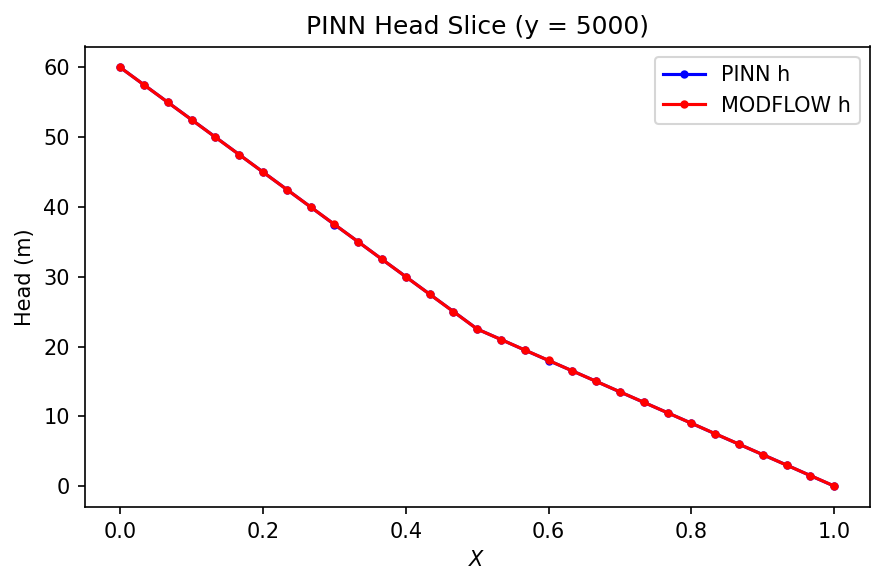

In [ ]:
def plot_head_slice_with_extra(X_phys, Y_phys, h, y0_phys, title, xlabel, ylabel, extra_h_vals):
    """
    - X_phys, Y_phys: 2D meshgrid(physical coordinates)
    - h: 2D array of head 값 (same shape as X_phys/Y_phys)
    - y0_phys: y = 5000 같은 물리 단위 상의 슬라이스 위치
    - extra_h_vals: y0_phys 위치에서 각 x 위치에 대응하는 추가로 찍을 Head 값 리스트 (1D, 길이는 x_line 길이와 일치)
    """
    # 1) Find the row index closest to y0_phys
    y_column = Y_phys[:, 0]
    idx = np.argmin(np.abs(y_column - y0_phys))

    # 2) x_line (x-coordinates of that row), h_line (existing PINN predicted head)
    x_line = X_phys[idx, :]      # [N,] shape
    h_line = h[idx, :]           # [N,] shape

    # 3) Verify if extra_h_vals has the same length as x_line
    extra_h_vals = np.array(extra_h_vals, dtype=float)
    if extra_h_vals.shape[0] != x_line.shape[0]:
        raise ValueError(f"extra_h_vals 길이({extra_h_vals.shape[0]})가 x_line 길이({x_line.shape[0]})와 다릅니다.")

    # 4) Generate Plot
    plt.figure(figsize=(6, 4), dpi=150)

    # 4-1) Existing PINN predicted head (Blue line + Circle marker)
    plt.plot(x_line, h_line, '-o', color='b', markersize=3, label='PINN h')

    # 4-2) New additional Head values (Red line + Circle marker)
    plt.plot(x_line, extra_h_vals, '-o', color='r', markersize=3, label='MODFLOW h')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{title} (y = {y0_phys})")
    plt.legend()
    plt.tight_layout()
    plt.show()

y0_phys = 5000
title_slice = "PINN Head Slice"
xlabel = "$X$"
ylabel = "Head (m)"

# (2) List of 31 additional Head values provided from MODFLOW results
extra_h_vals = [
    60.0,
    57.49975,
    54.99979,
    52.49998,
    50.00008,
    47.50013,
    45.00013,
    42.50008,
    40.00001,
    37.49995,
    34.99994,
    32.49998,
    30.00009,
    27.50023,
    25.00041,
    22.50039,
    21.00112,
    19.50103,
    18.00114,
    16.5011,
    15.00104,
    13.50095,
    12.00081,
    10.50067,
    9.000545,
    7.500456,
    6.000426,
    4.500473,
    3.000535,
    1.500592,
    0.0
]

# (3) Call the function
# Note: Ensure you pass the physical coordinate grids (e.g., X_org, Y_org) here.
plot_head_slice_with_extra(
    X, Y, pinn_h_final, y0_phys,
    title_slice, xlabel, ylabel,
    extra_h_vals
)


In [ ]:
# 30% random sampling and RMSE calculation

base_path = os.getcwd()
data_folder = os.path.join(base_path, 'data')
file_name = 'Case1.txt'
file_path = os.path.join(data_folder, file_name)

# 1. Check file existence and load
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Can not find data file: {file_path}")

try:
    # 2. Load Data
    df = pd.read_csv(file_name, skipinitialspace=True)
    df.columns = df.columns.str.replace('"', '').str.strip()

    # 3. Filter Active Cells and Remove Outliers
    if 'Active' in df.columns:
        df_active = df[df['Active'] == 1].copy()
    else:
        df_active = df[(df['f'] > -1000) & (df['f'] < 10000)].copy()

    # 4. Coordinate Transformation (Physical & Normalized)
    Nx_mf = df['j'].max()
    Ny_mf = df['i'].max()
    L_x, L_y = 10000.0, 10000.0
    dx_phys, dy_phys = L_x / Nx_mf, L_y / Ny_mf

    df_active['x_phys'] = (df_active['j'] - 0.5) * dx_phys
    df_active['y_phys'] = L_y - (df_active['i'] - 0.5) * dy_phys

    df_active['x_norm'] = df_active['x_phys'] / L_x # 0.0 ~ 1.0
    df_active['y_norm'] = df_active['y_phys'] / L_y # 0.0 ~ 1.0


    if 'best_params_left' not in locals() or 'best_params_right' not in locals():
        raise NameError("best_params_left 또는 best_params_right가 정의되지 않았습니다.")

    # Interface Position (x = 0.5)
    interface_x = 0.5

    # Split Data (Create Masks)
    mask_left = df_active['x_norm'] <= interface_x
    mask_right = ~mask_left

    # Initialize Prediction Array (Same size as MODFLOW values)
    h_pinn_combined = np.zeros(len(df_active))

    # --- (1) Left Domain Prediction ---
    if mask_left.any():
        df_left = df_active[mask_left]
        x_in_L = df_left['x_norm'].values.reshape(-1, 1)
        y_in_L = df_left['y_norm'].values.reshape(-1, 1)

        # Predict with Left Model
        # (Note: Left model trained to output h for inputs x in 0~0.5)
        h_pred_L = neural_net(best_params_left, jnp.array(x_in_L), jnp.array(y_in_L))
        h_pinn_combined[mask_left] = np.array(h_pred_L).flatten()

    # --- (2) Right Domain Prediction ---
    if mask_right.any():
        df_right = df_active[mask_right]
        x_in_R = df_right['x_norm'].values.reshape(-1, 1)
        y_in_R = df_right['y_norm'].values.reshape(-1, 1)

        # Predict with Right Model
        h_pred_R = neural_net(best_params_right, jnp.array(x_in_R), jnp.array(y_in_R))
        h_pinn_combined[mask_right] = np.array(h_pred_R).flatten()

    # Prepare Total Predictions and True Values
    h_pinn = h_pinn_combined
    h_mf = df_active['f'].values

    # 30% Random Sampling and RMSE Calculation
    N_total = len(h_mf)
    sample_ratio = 0.30
    n_samples = int(N_total * sample_ratio)

    rng = np.random.default_rng(seed=42)
    random_indices = rng.choice(N_total, size=n_samples, replace=False)

    h_pinn_sampled = h_pinn[random_indices]
    h_mf_sampled = h_mf[random_indices]

    diff = h_pinn_sampled - h_mf_sampled
    rmse = np.sqrt(np.mean(diff**2))

    print(f"\nRMSE (sampled 30%): {rmse:.4f} m")

    # --- Visualization ---
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(h_mf, h_pinn, alpha=0.1, s=5, c='gray', label='All Points')
    plt.scatter(h_mf_sampled, h_pinn_sampled, alpha=0.6, s=15, c='dodgerblue', label='Sampled (30%)')

    min_val = min(h_mf.min(), h_pinn.min())
    max_val = max(h_mf.max(), h_pinn.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')

    plt.xlabel("MODFLOW Head (m)")
    plt.ylabel("PINN Head (m)")
    plt.title(f"Sub-domain Comparison (RMSE={rmse:.4f}m)")
    plt.legend()
    plt.grid(True, linestyle='--')

    plt.subplot(1, 2, 2)
    x_all = df_active['x_phys'].values
    y_all = df_active['y_phys'].values
    x_sampled = x_all[random_indices]
    y_sampled = y_all[random_indices]

    plt.scatter(x_all, y_all, s=5, c='lightgray', marker='o', label='All Grid')
    plt.scatter(x_sampled, y_sampled, s=20, c='r', marker='x', label='Selected 30%')
    # 인터페이스 라인 표시
    plt.axvline(x=5000, color='k', linestyle='--', label='Interface (x=0.5)')

    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.title("Sampled Locations")
    plt.legend(loc='upper right', fontsize='small')
    plt.axis('equal')
    plt.grid(True, linestyle=':')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")

'case4_parallel_nodiffhead_chd_251029_dataset - case3.txt' 파일이 없습니다. 업로드를 진행합니다.


Error: [Errno 2] No such file or directory: 'case4_parallel_nodiffhead_chd_251029_dataset - case3.txt'
